In [1]:
import os, sys, numpy as np
import histogram.hdf as hh
import mcvine, mcvine.components

from matplotlib import pyplot as plt
%matplotlib notebook

from mcvine import run_script

/SNS/software/miniconda2/envs/spida/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
workdir = os.path.expanduser("~/simulations/mcvine/qikr")
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/simulations/mcvine/qikr


# Create instrument

In [3]:
sys.path.insert(0, os.path.expanduser("~/dv/neutrons/qikr/"))

In [4]:
import sample_component, detector
reload(sample_component)
reload(detector)

<module 'detector' from '/SNS/users/lj7/dv/neutrons/qikr/detector.pyc'>

In [5]:
%%file testdet.py
import numpy as np
import os, sys, numpy as np
import histogram.hdf as hh
import mcvine, mcvine.components

sys.path.insert(0, os.path.expanduser("~/dv/neutrons/qikr/"))
from sample_component import Sample
from detector import Detector

def R(Q):
    return np.exp(-Q*Q/25.)

def instrument(theta=6., sam2det=2.):
    instrument = mcvine.instrument()

    source = mcvine.components.sources.Source_simple(
        'source', radius=0., width=0.001, height=0.001, dist=1.0, xw=0.005, yh=0.005, Lambda0=3, dLambda=6)
    instrument.append(source, position=(0,0,0))

    sample_position = mcvine.components.optics.Arm()
    instrument.append(sample_position, position=(0,0,1))

    from sample_component import Sample
    sample = Sample('sample', xwidth=0.02, zheight=0.1, rq=R)
    instrument.append(sample, position=(0,0,0), orientation=(-theta, 0, 0), relativeTo=sample_position)
    
    from detector import Detector
    det = Detector('detector', xwidth=0.1792, yheight=0.2128, dx=0.0007, dy=0.0007, outfile='events.npy')
    twotheta_radian = np.deg2rad(2*theta)
    instrument.append(
        det,
        position=(0, sam2det*np.sin(twotheta_radian), sam2det*np.cos(twotheta_radian)),
        orientation=(-2*theta, 0, 0),
        relativeTo=sample_position)
    return instrument

Overwriting testdet.py


# Run a test simulation

In [6]:
%%time
!rm -rf ./debug-detector/
run_script.run1('./testdet.py', workdir='./debug-detector', ncount=int(1e6), overwrite_datafiles=False)

(256, 304)
CPU times: user 4.74 s, sys: 683 ms, total: 5.42 s
Wall time: 5.77 s


In [7]:
ls ./debug-detector/step0/

events.npy  number_of_mc_samples


# Load Events

In [8]:
events = np.load('./debug-detector/step0/events.npy')

In [9]:
events.shape

(749913,)

# Make a 2D histogram of the events

In [10]:
index = events['pixelID']

In [11]:
Nx, Ny = 256, 304

In [12]:
yindex = index % Ny
xindex = index // Ny

In [13]:
ixy, xbbs, ybbs = np.histogram2d(xindex, yindex, bins=(np.arange(Nx), np.arange(Ny)), weights=events['p'])

<IPython.core.display.Javascript object>


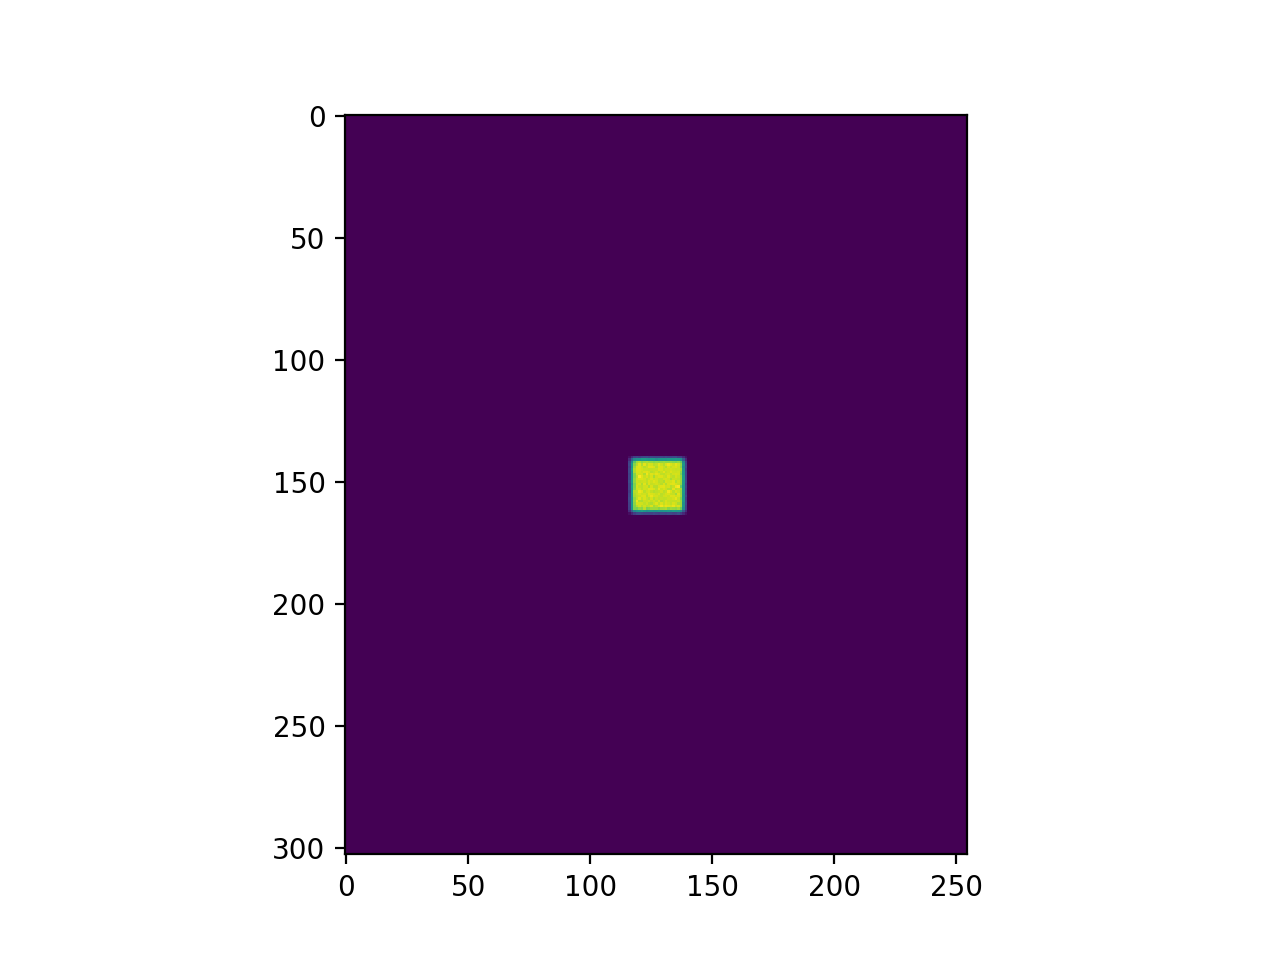

In [14]:
plt.figure()
plt.imshow(ixy.T)

# Convert to nexus file

In [15]:
from mantid2mcvine.nxs import template as nxs_template, Events2Nxs

In [16]:
nxs_template.create(
    os.path.expanduser('~/.mantid/instrument/REF_L_Definition.xml'), 
    ntotpixels = Nx*Ny, outpath='template.nxs', pulse_time_end=1e5
)

/SNS/software/miniconda2/envs/spida/lib/python2.7/site-packages/mantid/kernel/__init__.py:23: RuntimeWarning: to-Python converter for std::vector<int, std::allocator<int> > already registered; second conversion method ignored.
  from ._kernel import *
/SNS/software/miniconda2/envs/spida/lib/python2.7/site-packages/mantid/kernel/__init__.py:23: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.
  from ._kernel import *


'template.nxs'

In [17]:
e2n = Events2Nxs.Event2Nxs('./template.nxs', npixels=Nx*Ny, nmonitors=1)

In [18]:
e2n.run('./debug-detector/step0/events.npy', 'sim.nxs')

Converting ./debug-detector/step0/events.npy to sim.nxs
